#8장 생성 모델을 위한 딥러닝

## 8-1 LSTM으로 텍스트 생성하기

### 8-1-1 생성 RNN의 간단한 역사

### 8-1-2 시퀀스 데이터를 어떻게 생성할까?

### 8-1-3 샘플링 전략의 중요성

In [ ]:
import numpy as np

def reweight_distribution(original_distribution , temperature = 0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

### 8-1-4 글자 수준의 LSTM 텍스트 생성 모델 구현

#### 데이터 전처리

In [ ]:
import tensorflow as tf
import keras
import numpy as np

path = tf.keras.utils.get_file(
    'nietzsche.txt',
    origin = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('말뭉치 크기:' , len(text))

614400/600901 [==============================] - 0s 0us/step
말뭉치 크기: 600893


In [ ]:
maxlen = 60
step = 3

sentences = []

next_chars = []

for i in range(0 , len(text) - maxlen , step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[ i + maxlen])

print('시퀀스 개수:' , len(sentences))

chars = sorted(list(set(text)))
print('고유한 글자:' , len(chars))
char_indices = dict((char , chars.index(char)) for char in chars)

print('벡터화... ')
x = np.zeros((len(sentences) , maxlen , len(chars)) , dtype =np.bool)
y = np.zeros((len(sentences) , len(chars)) , dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t , char_indices[char]] = 1
    y[i , char_indices[next_chars[i]]] = 1

시퀀스 개수: 200278
고유한 글자: 57
벡터화... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


#### 네트워크 구성

In [ ]:
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128 , input_shape=(maxlen , len(chars))))
model.add(layers.Dense(len(chars) , activation='softmax'))

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(lr = 0.01)
model.compile(loss = 'categorical_crossentropy' , optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#### 언어 모델 훈련과 샘플링

In [ ]:
def sample(preds , temperature = 1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1 , preds , 1)
    return np.argmax(probas)

In [ ]:
import random
import sys

random.seed(42)
start_index = random.randint(0 , len(text) - maxlen - 1)

for epoch in range(1 , 60):
    print('에포크' , epoch)
    model.fit(x,y,batch_size = 128  ,epochs = 1)
    
    seed_text = text[start_index: start_index + maxlen]
    print('--- 시드 텍스트: "'  + seed_text + '"')

    for temperature in [0.2 , 0.5 , 1.0 , 12]:
        print('------ 온도:' , temperature)
        generated_text = seed_text
        sys.stdout.write(generated_text)

        for i in range(400):
            samples = np.zeros((1 , maxlen , len(chars)))
            for t, char in enumerate(generated_text):
                samples[0 , t , char_indices[char]] = 1.

            preds = model.predict(samples , verbose = 0)[0]
            next_index = sample(preds , temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()

        print()

에포크 1
1565/1565 [==============================] - 27s 17ms/step - loss: 1.6187
--- 시드 텍스트: "the slowly ascending ranks and classes, in which,
through fo"
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through for the still to the same a can self-contradention of the still to the many the many some some the stringer of the still to the properse of the same always it is the still the propersion, and the cause of the still the more properse of the still to the stringer that is the fact of the stringer and some the stringer the say, and the still to the strength of the same the senses of the sounce, and the 
------ 온도: 0.5
the slowly ascending ranks and classes, in which,
through for the still of every incrosence of the readity and the same the cause the intertanting the paint and at an it is he place light in the disture discare as the istention, the sentimently always always by the something that the sciences of the same stringer that the personed as a stilled of the s

KeyboardInterrupt: ignored

## 8-2 딥드림

### 8-2-1 케라스 딥드립 구현

In [ ]:
!pip install keras==2.2

  Using cached Keras_Applications-1.0.2-py2.py3-none-any.whl (43 kB)
  Using cached Keras_Preprocessing-1.0.1-py2.py3-none-any.whl (26 kB)
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Attempting uninstall: keras-applications
    Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 1.13.1 requires keras-applications>=1.0.6, but you have keras-applications 1.0.2 which is incompatible.
tensorflow 1.13.1 requires keras-preprocessing>=1.0.5, but you have keras-preprocessing 1.0.1 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you ha

In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 1.13.1
Uninstalling tensorflow-1.13.1:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-1.13.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.13.1


In [ ]:
!pip install tensorflow==1.13.1

  Using cached tensorflow-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (92.6 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.0.1
    Uninstalling Keras-Preprocessing-1.0.1:
      Successfully uninstalled Keras-Preprocessing-1.0.1
  Attempting uninstall: keras-applications
    Found existing installation: Keras-Applications 1.0.2
    Uninstalling Keras-Applications-1.0.2:
      Successfully uninstalled Keras-Applications-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras 2.2.0 requires keras-applications==1.0.2, but you have keras-applications 1.0.8 which is incompatible.
keras 2.2.0 requires keras-preprocessing==1.0.1, but you have keras-preprocessing 1.1.2 which is inco

In [ ]:
from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights = 'imagenet' , include_top = False)

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

AttributeError: ignored

In [ ]:
layer_contributions = {
    'mixed2' : 0.2,
    'mixed3' : 0.3,
    'mixed4' : 2.,
    'mixed5' : 1.5,
}

In [ ]:
layer_dict = dict([(layer.name , layer) for layer in model.layers]) 

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation) , 'float32'))
    loss = loss +  coeff * K.sum(K.square(activation[: , 2: -2 , 2:-2 , :])) / scaling

In [ ]:
dream = model.input

grads = K.gradients(loss , dream)[0]

preds /= K.maximum(K.mean(K.abs(grads)) , 1e-7)

outputs = [loss , grads]
fetch_loss_and_grads = K.function([dream] , outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value , grad_values

def gradient_ascent(x , iterations , step , max_loss = None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...' , i , '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [ ]:
import numpy as np

step = 0.01 
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10.

base_image_path = './datasets/original_photo_deep_dream.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
    for dim in origianl_shape])
    succesi

#### 딥드림은 스킵 합니다....

### 8-3 뉴럴 스타일 트랜스퍼

### 8-3-1 콘텐츠 손실

### 8-3-2 스타일 손실

### 8-3-3 케라스에서 뉴럴 스타일 트랜스퍼 구현하기

In [2]:
from keras.preprocessing.image import load_img , img_to_array , save_img

target_image_path = '/content/drive/MyDrive/AI/독학/케라스 창시자/portrait/portrait.jpg'
style_reference_image_path = '/content/drive/MyDrive/AI/독학/케라스 창시자/portrait/popova.jpg'

width , height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [3]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size = (img_height , img_width))
    img = img_to_array(img)
    img = np.expand_dims(img , axis = 0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[: , : , 0] += 103.939
    x[: , : , 1] += 116.779
    x[: , : , 2] += 123.68
    x = x[: , : , ::-1]
    x = np.clip(x , 0 , 255).astype('unit8')
    return x

In [11]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1 , img_height , img_width , 3))

input_tensor = K.concatenate([target_image, 
                              style_reference_image , 
                              combination_image] , axis = 0)

model = vgg19.VGG19(input_tensor  = input_tensor , 
                    weights = 'imagenet',
                    include_top = False)

print('모델 로드 완료')

모델 로드 완료


In [12]:
def content_loss(base , combination):
    return K.sum(K.square(combination - base))

In [13]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x , (2,0,1)))
    gram = K.dot(features , K.transpose(features))
    return gram

def style_loss(style , combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [14]:
def total_variation_loss(x):
    a = K.square(
        x[: , :img_height - 1 , :img_width - 1 , :] -
        x[:, 1: , :img_width - 1 , :])
    b = K.square(
        x[: , :img_height - 1 , :img_width - 1 , :] -
        x[: , :img_height - 1 , 1: , :])
    
    return K.sum(K.pow(a + b, 1.25))

In [15]:
outputs_dict = dict([(layer.name , layer.output) for layer in model.layers])

content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[ 0 ,: , : , :]
combination_features = layer_features[2 , : , : , :]
loss = loss + content_weight * content_loss(target_image_features , combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, : , : , : ]
    combination_features = layer_features[2 , : , : , : ]
    sl = style_loss(style_reference_features , combination_features)
    loss += (style_weight / len(style_layers)) * sl

loss = loss +  total_variation_weight * total_variation_loss(combination_image) 

In [16]:
#import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

grads = K.gradients(loss , combination_image)[0]

fetch_loss_and_grads = K.function([combination_image] , [loss,grads])

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1 , img_height , img_width , 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.loss_values = grad_values
        return self.loss_value

    def grads(self , x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [18]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:' , i)
    start_time = time.time()
    print(len(x))
    x, min_val , info = fmin_l_bfgs_b(func = evaluator.loss,
                                      x0 = x,
                                      fprime=evaluator.grads,
                                      maxfun=20,
                                      m=10)
    print('현재 손실 값:' , min_val)
    img = x.copy().reshape((img_height , img_width , 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname , img)
    print('저장 이미지' , fname)
    end_time = time.time()
    print('%d 번째 반복 완료: %ds' % (i , end_time - start_time))

반복 횟수: 0
721200


ValueError: ignored

## 8-4 변이형 오토인코더를 사용한 이미지 생성

### 8-4-1 이미지의 잠재공간에서 샘플링하기

### 8-4-2 이미지 변형을 위한 개념 벡터

### 8-4-3 변이형 오토인코더

In [19]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28 , 28 , 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32 , 3 , padding='same' , activation='relu')(input_img)

x = layers.Conv2D(64 , 3 , padding='same' , activation='relu' , strides = (2,2))(x)

x = layers.Conv2D(64 , 3 , padding='same' , activation='relu')(x)

x = layers.Conv2D(64 , 3 , padding='same' , activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32 , activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [21]:
def sampling(args):
    z_mean , z_log_var = args

    epsilon = K.random_normal(shape=(K.shape(z_mean)[0] , latent_dim) , mean=0. , stddev=1.)

    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean , z_log_var])

In [22]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation = 'relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32 , 3,
                           padding = 'same' ,
                           activation = 'relu' , 
                           strides=(2,2))(x)
x = layers.Conv2D(1 , 3,
                  padding = 'same',
                  activation = 'sigmoid')(x)

decoder = Model(decoder_input , x)

z_decoded = decoder(z)

In [26]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self , x , z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x , z_decoded)
        kl_loss = -5e-4 * K.mean(
            1+ z_log_var - K.square(z_mean) - K.exp(z_log_var) , axis = -1)
        return K.mean(xent_loss + kl_loss)

    def call(self , inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x , z_decoded)
        self.add_loss(loss , inputs = inputs)
        return x

y = CustomVariationalLayer()([input_img , z_decoded])

In [28]:
from keras.datasets import mnist

vae = Model(input_img , y)
vae.compile(optimizer='rmsprop' , loss = None)
vae.summary()

(x_train, _) , (x_test , y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape +(1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train , y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data = (x_test , None))


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 434s 7ms/sample - loss: 1676455899.0773 - val_loss: 0.1994
Epoch 2/10
60000/60000 [==============================] - 417s 7ms/sample - loss: 0.1952 - val_loss: 0.1917
Epoch 3/10
60000/60000 [==============================] - 319s 5ms/sample - loss: 0.1907 - val_loss: 0.1891
Epoch 4/10
60000/60000 [==============================] - 318s 5ms/sample - loss: 0.1883 - val_loss: 0.1874
Epoch 5/10
60000/60000 [==============================] - 319s 5ms/sample - loss: 0.1868 - val_loss: 0.1879
Epoch 6/10
60000/60000 [==============================] - 319s 5ms/sample - loss: 0.1857 - val_loss: 0.1856
Epoch 7/10
60000/60000 [==============================] - 322s 5ms/sample - loss: 0.1848 - val_loss: 0.1841
Epoch 8/10
60000/60000 [==============================] - 327s 5ms/sample - loss: 0.1840 - val_loss: 0.1835
Epoch 9/10
60000/60000 [==============================] - 404s 7ms/sample - loss: 0.1833 - val_loss: 0.1837
Epoch 10/10
60000/60000 [=====

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


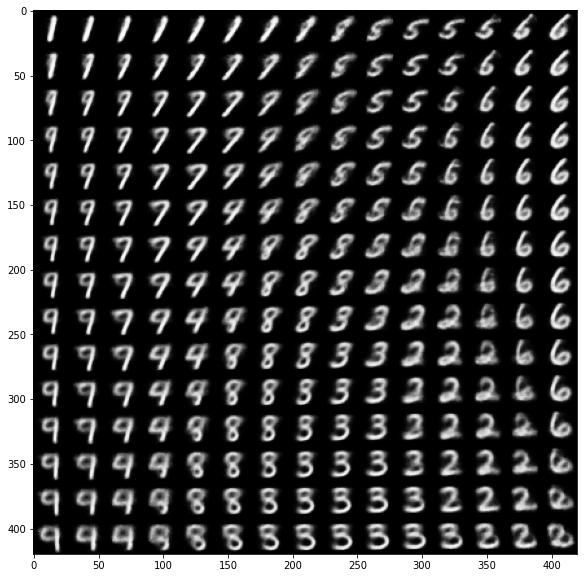

In [30]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n , digit_size * n))
grid_x = norm.ppf(np.linspace(0.05 , 0.95 , n))
grid_y = norm.ppf(np.linspace(0.05 , 0.95 , n))

for i , yi in enumerate(grid_x):
    for j , xi in enumerate(grid_y):
        z_sample = np.array([[xi , yi]])
        z_sample = np.tile(z_sample , batch_size).reshape(batch_size , 2)
        x_decoded = decoder.predict(z_sample , batch_size = batch_size)

        digit = x_decoded[0].reshape(digit_size , digit_size)
        figure[i * digit_size : (i+1) * digit_size,
               j * digit_size : (j+1) * digit_size] = digit

plt.figure(figsize=(10 , 10))
plt.imshow(figure , cmap='Greys_r')
plt.show()

### 8-4-4 정리

## 8-5 적대적 생성 신경망 소개

### 8-5-1 GAN 구현 방법

### 8-5-2 훈련 방법

### 8-5-3 생성자

In [40]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16 , 16, 128))(x)

x = layers.Conv2D(256 , 5 , padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256 , 5 , padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256 , 5 , padding = 'same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels , 7 , activation='tanh' , padding='same')(x)
generator = keras.models.Model(generator_input , x)
generator.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_12 (Dense)            (None, 32768)             1081344   
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 32768)             0         
                                                                 
 reshape_4 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 256)       1638

### 8-5-4 판별자

In [ ]:
discriminator_input = layers.Input(shape=(height , width , channels))
x = layers.Conv2D(128 , 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128 , 4 , strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128 , 4 , strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128 , 4 , strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1 , activation='sigmoid')(x)

discriminator = keras.models.Model( discriminator_input , x )
discriminator.summary()

discriminator.summary()

discriminator_optimizer = tf.keras.optimizers.RMSprop(
    lr = 0.0008 ,
    clipvalue=1.0,
    decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, loss = 'binary_crossentropy')

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_53 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 30, 30, 128)       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 6, 6, 128)         0  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
